# Clustering

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from collections import Counter

sns.set_theme()

To start, let's pull in the data from data_exploration.ipynb

In [2]:
comments = pd.read_pickle("../private/top_100_processed.pkl")

Now vectorize it so we can cluster it!

In [3]:
vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
comments_tfidf = vectorizer.fit_transform(comments.text)

Now to try to see if there are any clusters...

In [4]:
svd_model = TruncatedSVD(n_components=2)            # slim down to 2 dimensions!
comments_svd = svd_model.fit_transform(comments_tfidf)

In [5]:
comments_svd.shape

(118299, 2)

<Axes: >

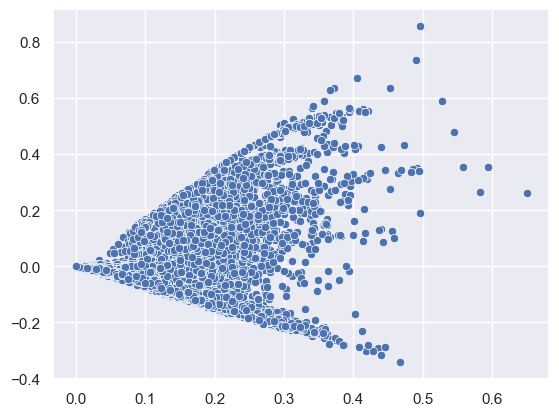

In [6]:
sns.scatterplot(x=comments_svd[:, 0], y=comments_svd[:, 1])

Hmm, no obvious clusters here, but a wide spread! Maybe just a decently high number?

In [7]:
# Slightly modified from activity 7
def display_topics(model, feature_names, num_top_words):
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))


I'm going to try both NML and LDA to see which one has better looking clusters.

In [8]:
num_topics = 8

nmf_model = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(comments_tfidf)

display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
just don people time know did ve want think really
Topic 1:
love absolutely fucking man oh guy omg cats idea god
Topic 2:
beautiful absolutely thank work seen wow picture photo sharing tattoo
Topic 3:
good job looks dad boy luck really man pretty damn
Topic 4:
like looks look sounds dog feel delicious painting really feels
Topic 5:
amazing looks work absolutely thank job fucking sharing did omg
Topic 6:
cute cat omg lol little dog adorable aww oh super
Topic 7:
great wow awesome nice job cool work really looks picture


In [9]:
def display_topics2(H, W, feature_names, docs, num_top_words, num_top_docs):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print('--------')
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:num_top_docs]

        # build list for frequency distribution
        subs = Counter()
        for doc_index in top_doc_indices:
            subs.update([docs.loc[doc_index].subreddit])
        print(subs.most_common(5))
        print('----------------------------------------------')

nmf_W = nmf_model.transform(comments_tfidf)    # topics-to-documents matrix
nmf_H = nmf_model.components_           # word-to-topics matrix
feat_names = vectorizer.get_feature_names_out()

# print top words, top-1 document from each topic
display_topics2(nmf_H, nmf_W, feat_names, comments, 10, 1000)

Topic 0:
just don people time know did ve want think really
--------
[('Parenting', 102), ('relationship_advice', 85), ('LifeProTips', 52), ('WritingPrompts', 38), ('Futurology', 25)]
----------------------------------------------
Topic 1:
love absolutely fucking man oh guy omg cats idea god
--------
[('tattoos', 88), ('gardening', 80), ('cats', 47), ('DIY', 45), ('itookapicture', 39)]
----------------------------------------------
Topic 2:
beautiful absolutely thank work seen wow picture photo sharing tattoo
--------
[('tattoos', 156), ('gardening', 138), ('EarthPorn', 83), ('itookapicture', 72), ('Art', 55)]
----------------------------------------------
Topic 3:
good job looks dad boy luck really man pretty damn
--------
[('sports', 44), ('PS4', 43), ('MadeMeSmile', 36), ('FoodPorn', 35), ('rarepuppers', 33)]
----------------------------------------------
Topic 4:
like looks look sounds dog feel delicious painting really feels
--------
[('itookapicture', 61), ('EarthPorn', 60), ('fo

In [10]:
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(comments_tfidf)

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
like just people don time good know ve make think
Topic 1:
love dog looks cat nice https like yes fucking com
Topic 2:
cute good adorable pretty holy shit seen best ve congrats
Topic 3:
beautiful awesome thank gorgeous op thanks proud sharing job great
Topic 4:
amazing bro stunning face banana bet imgur father grow wants
Topic 5:
sorry absolutely did day okay women birthday bitcoin rainbow weird
Topic 6:
wow cool happy oh lol fuck god sweet look damn
Topic 7:
great omg lmao funny savevideo dude crying wholesome fantastic wtf


Of these two, the results from LDA seem slightly more interesting to me, so I'll take a closer look at it, what's the distribution of subreddit for each of these topics?

In [11]:
# modified from activity 7
def display_topics2(H, W, feature_names, docs, num_top_words, num_top_docs):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print('--------')
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:num_top_docs]

        # build list for frequency distribution
        subs = Counter()
        for doc_index in top_doc_indices:
            subs.update([docs.loc[doc_index].subreddit])
        print(subs.most_common(5))
        print('----------------------------------------------')

lda_W = lda_model.transform(comments_tfidf)    # topics-to-documents matrix
lda_H = lda_model.components_           # word-to-topics matrix
feat_names = vectorizer.get_feature_names_out()

# print top words, top-1 document from each topic
display_topics2(lda_H, lda_W, feat_names, comments, 10, 1000)

Topic 0:
like just people don time good know ve make think
--------
[('Parenting', 76), ('AskReddit', 68), ('relationship_advice', 43), ('wholesomememes', 33), ('personalfinance', 33)]
----------------------------------------------
Topic 1:
love dog looks cat nice https like yes fucking com
--------
[('aww', 67), ('cats', 66), ('tifu', 44), ('ContagiousLaughter', 44), ('memes', 40)]
----------------------------------------------
Topic 2:
cute good adorable pretty holy shit seen best ve congrats
--------
[('aww', 76), ('AnimalsBeingDerps', 55), ('AnimalsBeingBros', 54), ('rarepuppers', 54), ('FoodPorn', 50)]
----------------------------------------------
Topic 3:
beautiful awesome thank gorgeous op thanks proud sharing job great
--------
[('gardening', 92), ('tattoos', 76), ('itookapicture', 42), ('EarthPorn', 37), ('Art', 36)]
----------------------------------------------
Topic 4:
amazing bro stunning face banana bet imgur father grow wants
--------
[('gardening', 40), ('Awwducational

I think this might be more interesting if we treat each subreddit as its own document, that might make the clusters more interesting

In [12]:
comments_1000 = pd.read_pickle("../private/top_1000_processed.pkl")
comments_1000.head()

,subreddit,comment_id,text,tokens,num_tokens,num_types,ttr,avg_word_len
0,funny,jg3d9yg,"""Oh my god! That's awful!"" Exactly how you wan...","[``, Oh, my, god, !, That, 's, awful, !, '', E...",24,22,0.916667,3.250000
1,funny,jg3af9r,Her eyes when he stood up.,"[Her, eyes, when, he, stood, up, .]",7,7,1.000000,3.000000
2,funny,jg3782t,the reporter's name is Brad Blanks,"[the, reporter, 's, name, is, Brad, Blanks]",7,7,1.000000,4.142857
3,funny,jg39vhb,**Jennifer:** What are you getting in the way-...,"[*, *, Jennifer, :, *, *, What, are, you, gett...",19,16,0.842105,2.526316
4,funny,jg36sqa,They “were scared…of my brutish height.” 😂,"[They, “, were, scared…of, my, brutish, height...",9,9,1.000000,4.000000


In [13]:
subreddits = comments[["subreddit", "text", "num_tokens", "num_types", "ttr", "avg_word_len"]].groupby("subreddit").agg(
    subreddit=("subreddit", "first"),
    text=("text", "\n".join),
    total_tokens=("num_tokens", "sum"),
    avg_tokens=("num_tokens", "mean"),
    ttr=("ttr", "mean"),
    avg_word_len=("avg_word_len", "mean"),
).reset_index(drop=True)
subreddits.head()

,subreddit,text,total_tokens,avg_tokens,ttr,avg_word_len
0,AdviceAnimals,Why bother even doing an AMA if they are only ...,34504,25.615442,0.903857,3.970445
1,AnimalsBeingBros,The rescue worker fireman said:\n\n> We rescue...,21064,13.704619,0.946698,4.153795
2,AnimalsBeingDerps,I love how he picked up on her concern when he...,29333,14.357807,0.939272,4.087738
3,AnimalsBeingJerks,I’ve long wondered how many hauntings really s...,15235,15.952880,0.933901,4.046530
4,Art,That land shark behind it is looking for its n...,21498,18.111205,0.931172,3.847400


Now that the comments are grouped as one document per subreddit, lets try clustering again!

In [14]:
vectorizer2 = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
subreddits_tfidf = vectorizer2.fit_transform(subreddits.text)

In [15]:
svd_model = TruncatedSVD(n_components=2)
subreddits_svd = svd_model.fit_transform(subreddits_tfidf)

<Axes: >

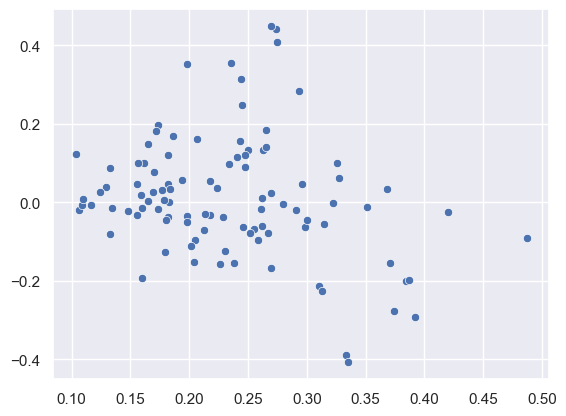

In [16]:
sns.scatterplot(x=subreddits_svd[:, 0], y=subreddits_svd[:, 1])

This looks like a more interesting shape? I think? It's kinda hard to tell... maybe there are some clusters here?

In [17]:
num_topics = 8

nmf_model = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(subreddits_tfidf)

display_topics(nmf_model, vectorizer2.get_feature_names_out(), 10)

Topic 0:
therapist therapy dolly rhino teacher obese mattress cops hospital gun
Topic 1:
cats adorable kitty savevideo sea fish geese giphy elephant puppy
Topic 2:
spez mods apps users apollo buttons subs rif api cancel
Topic 3:
crypto bitcoin btc bank robinhood banks wsb trading img tax
Topic 4:
trump republicans court thomas supreme gop president republican indicted fox
Topic 5:
tattoo gorgeous stunning painting wallpaper turtle portrait album mountains artwork
Topic 6:
pizza delicious cheese cake sauce rice pepperoni bbq recipe sprouts
Topic 7:
nato russia ukraine finland putin pis poland russian sweden rodgers


Oh wow these topics look a lot more like what I was looking for!

In [18]:
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(subreddits_tfidf)

display_topics(lda_model, vectorizer2.get_feature_names_out(), 10)

Topic 0:
chris tradition vacation partnership nicely reached chin gpa tinder grass
Topic 1:
warranty douche youngest crock messi na arrest alabama bankruptcy dealer
Topic 2:
trends susan 48 claims supporter mashed 1440p courage gg ethical
Topic 3:
rhinos freshman competitors filing clarify flawless asf medusa poles cape
Topic 4:
spez turtle socialism mixing evolution lion console nooooo doubts balloon
Topic 5:
painting recover trained bills translated afroman homelessness kittens screamed tile
Topic 6:
mods apps hank adorable pin esque utah cab initial senior
Topic 7:
moldy weight fomo prevented brightness ss aunt bruce fundamental takeout


These are... very much not better, let's stick with NMF then.

In [19]:
def display_topics3(H, W, feature_names, docs, num_top_words, num_top_docs):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print('--------')
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:num_top_docs]

        # build list for frequency distribution
        for doc_index in top_doc_indices:
            print(docs.loc[doc_index].subreddit)
        print('----------------------------------------------')

nmf_W = nmf_model.transform(subreddits_tfidf)    # topics-to-documents matrix
nmf_H = nmf_model.components_           # word-to-topics matrix
feat_names = vectorizer2.get_feature_names_out()

# print top words, top-1 document from each topic
display_topics3(nmf_H, nmf_W, feat_names, subreddits, 10, 5)

Topic 0:
therapist therapy dolly rhino teacher obese mattress cops hospital gun
--------
Parenting
AskReddit
relationship_advice
Documentaries
Futurology
----------------------------------------------
Topic 1:
cats adorable kitty savevideo sea fish geese giphy elephant puppy
--------
cats
aww
AnimalsBeingDerps
AnimalsBeingBros
AnimalsBeingJerks
----------------------------------------------
Topic 2:
spez mods apps users apollo buttons subs rif api cancel
--------
technology
programming
videos
cars
AdviceAnimals
----------------------------------------------
Topic 3:
crypto bitcoin btc bank robinhood banks wsb trading img tax
--------
Bitcoin
wallstreetbets
CryptoCurrency
personalfinance
mildlyinteresting
----------------------------------------------
Topic 4:
trump republicans court thomas supreme gop president republican indicted fox
--------
politics
news
AdviceAnimals
nottheonion
Jokes
----------------------------------------------
Topic 5:
tattoo gorgeous stunning painting wallpape